<a href="https://colab.research.google.com/github/khadija675/stock-prediction/blob/main/Stock_Price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import warnings

# Suppress Keras UserWarning about input_shape
warnings.filterwarnings('ignore', category=UserWarning)


In [55]:

# Define the lookback window
time_step = 60
NUM_FEATURES = 5 # Open, High, Low, Close, Volume

# Utility function to create sequences for LSTM training with multiple features
def create_dataset_multi_feature(dataset, target_index, time_step=time_step):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        # X: all 5 features for 'time_step' days
        dataX.append(dataset[i:(i + time_step), :])
        # Y: the 'close' price (target_index) one step ahead
        dataY.append(dataset[i + time_step, target_index])
    return np.array(dataX), np.array(dataY)

In [56]:
# Utility function for Inverse Transformation (since scaler was fit on 5 columns)
def inverse_transform_predictions(predictions, scaler, target_index, num_features=NUM_FEATURES):
    # Create a dummy array of zeros for all 5 features
    temp = np.zeros((len(predictions), num_features))
    # Place the predicted 'close' price into the correct column (TARGET_INDEX)
    temp[:, target_index] = predictions[:, 0]
    # Inverse transform the entire array and return only the target column
    return scaler.inverse_transform(temp)[:, target_index]

Data Preprocessing, Split, and Feature Engineering

In [57]:
# --- Load and Select Features ---
df = pd.read_csv('AAPL.US_D1.csv')
features = ['open', 'high', 'low', 'close', 'volume']
df_features = df[features]

TARGET_INDEX = df_features.columns.get_loc('close')
data_array = df_features.values

# --- Define Sequential Split Sizes (65% Train, 15% Validation, 20% Test) ---
data_len = len(data_array)
train_size = int(data_len * 0.65)
val_size = int(data_len * 0.15)
test_size = data_len - train_size - val_size

# --- Create Sequential Data Subsets ---
train_data = data_array[0:train_size]
val_data = data_array[train_size:train_size + val_size]
test_data = data_array[train_size + val_size:data_len]

# --- Correct Scaling: Fit ONLY on Training Data (for all 5 features) ---
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(train_data)

# --- Transform all sets using the fitted scaler ---
train_scaled = scaler.transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

# --- Inspect Scaled Training Data ---
print("--- Scaled Training Data Head (First 5 rows of 5 features) ---")
print(pd.DataFrame(train_scaled, columns=features).head().to_markdown(index=False))

# --- Create LSTM Sequences ---
X_train, y_train = create_dataset_multi_feature(train_scaled, TARGET_INDEX, time_step)
X_val, y_val = create_dataset_multi_feature(val_scaled, TARGET_INDEX, time_step)
X_test, y_test = create_dataset_multi_feature(test_scaled, TARGET_INDEX, time_step)

# The data is already in the correct 3D shape: [samples, time_steps, features]

# --- Inspect Training Data Shape ---
print("\n--- Training Data Shape ---")
print(f"X_train shape (samples, time_steps, features): {X_train.shape}")

--- Scaled Training Data Head (First 5 rows of 5 features) ---
|        open |        high |         low |       close |    volume |
|------------:|------------:|------------:|------------:|----------:|
| 0           | 0           | 0           | 0           | 0.102557  |
| 0.000604047 | 0           | 0.000306091 | 0           | 0.0912794 |
| 0.000604047 | 0.000901984 | 0.000306091 | 0.00060423  | 0.268721  |
| 0.00120809  | 0.000601323 | 0.000918274 | 0.000302115 | 0.154067  |
| 0.000906071 | 0.000601323 | 0.000918274 | 0.00060423  | 0.114239  |

--- Training Data Shape ---
X_train shape (samples, time_steps, features): (4254, 60, 5)


Model Building

training

Prediction and Evaluation

In [71]:
# --- Model Definition with Dropout Regularization ---
# Input shape is (60 time_steps, 5 features)
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_step, NUM_FEATURES)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# --- Define Early Stopping Callback ---
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    verbose=1,
    restore_best_weights=True
)

# --- Train the Model ---
print("\n--- Model Training Starting (with Early Stopping) ---")
history = model.fit(
    X_train, y_train,
    epochs=500, # Set high, EarlyStopping will stop it
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

# --- Output Number of Epochs Trained ---
final_epochs = len(history.history['loss'])
print(f"\n--- Model Training Finished ---")
print(f"Model trained for a total of {final_epochs} epochs (optimal stop point determined by EarlyStopping).")


# --- Prediction and Evaluation ---

# 1. Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 2. Inverse transform predictions to original scale and actual values
train_predict_inv = inverse_transform_predictions(train_predict, scaler, TARGET_INDEX)
test_predict_inv = inverse_transform_predictions(test_predict, scaler, TARGET_INDEX)
y_train_inv = inverse_transform_predictions(y_train.reshape(-1, 1), scaler, TARGET_INDEX)
y_test_inv = inverse_transform_predictions(y_test.reshape(-1, 1), scaler, TARGET_INDEX)

# 3. Calculate Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict_inv))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv))

print(f"\nTrain RMSE: ${train_rmse:.4f}")
print(f"Test RMSE: ${test_rmse:.4f}")


# --- 4. Future Prediction (10 and 30 Days) ---
print("\n--- Generating Future Predictions ---")

def predict_future(model, initial_input, steps, scaler, target_index):
    """Predicts stock price for 'steps' into the future using a sliding window."""
    temp_input = list(initial_input)
    lst_output = []

    for i in range(steps):
        # We need the last 'time_step' rows (60 days) of the multi-feature input
        x_input = np.array(temp_input[-time_step:])
        x_input = x_input.reshape(1, time_step, NUM_FEATURES)

        yhat = model.predict(x_input, verbose=0)

        # Create the new input row: take the last input row, and update the 'close' price
        new_input_row = x_input[0, -1, :].copy()
        new_input_row[target_index] = yhat[0, 0] # Replace the 'close' price with the prediction

        temp_input.append(new_input_row)
        lst_output.append(yhat[0, 0])

    # Inverse transform the final prediction list
    future_predictions = np.array(lst_output).reshape(-1, 1)
    future_predictions_inv = inverse_transform_predictions(future_predictions, scaler, target_index)
    return future_predictions_inv

# Start with the last time_step points from the scaled test data
last_input = test_scaled[-time_step:]

pred_10_days = predict_future(model, last_input, 10, scaler, TARGET_INDEX)
pred_30_days = predict_future(model, last_input, 30, scaler, TARGET_INDEX)

print(f"10-Day Future Price Prediction: ${pred_10_days[-1]:.4f}")
print(f"30-Day Future Price Prediction: ${pred_30_days[-1]:.4f}")

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 60, 100)        │        42,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,901 (480.08 KB)

 Trainable params: 122,901 (480.08 KB)

 Non-trainable params: 0 (0.00 B)


--- Model Training Starting (with Early Stopping) ---
Epoch 1/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.0191 - val_loss: 0.0142
Epoch 2/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 8.5550e-04 - val_loss: 0.0074
Epoch 3/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 6.8312e-04 - val_loss: 0.0038
Epoch 4/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 6.3503e-04 - val_loss: 0.0047
Epoch 5/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 7.2232e-04 - val_loss: 0.0042
Epoch 6/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - loss: 5.7778e-04 - val_loss: 0.0027
Epoch 7/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 7.3696e-04 - val_loss: 0.0040
Epoch 8/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 5.6430e-04 - val_loss: 0.0033
Epoch 9/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - loss: 5.6180e-04 - val_loss: 0.0040
Epoch 10/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 5.6851e-04 - val_loss: 0.0030
Epoch 11/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 

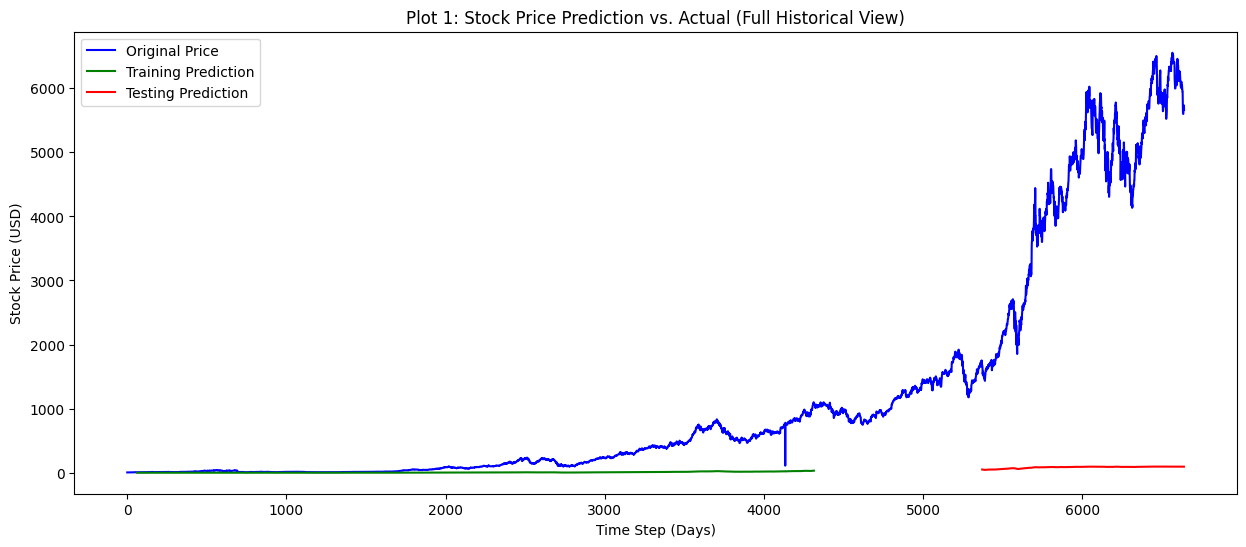


Plot 1: Full Historical Prediction saved as 'stock_prediction_full_history.png'.


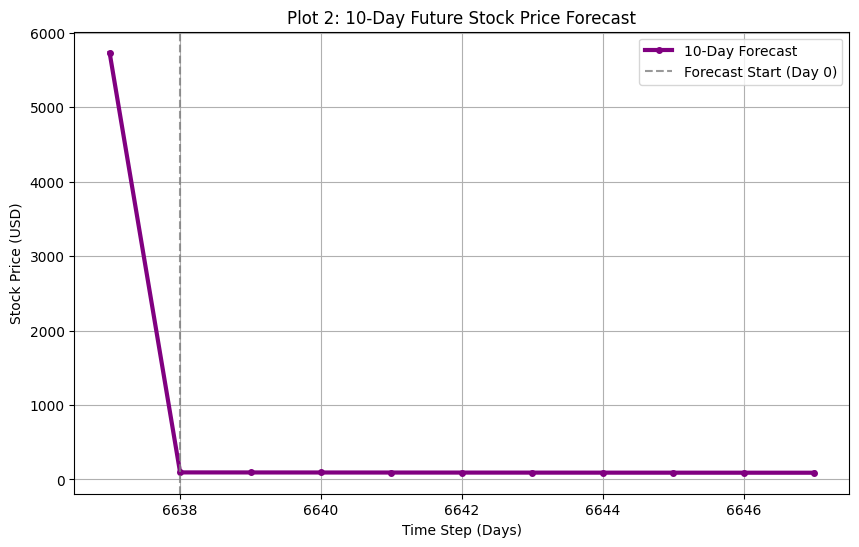

Plot 2: 10-Day Forecast saved as 'stock_prediction_10_day_forecast_isolated.png'.


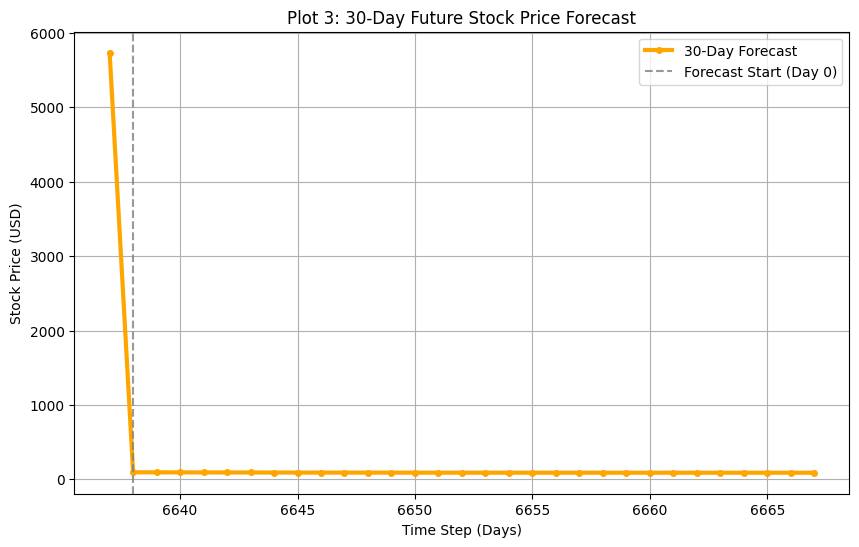

Plot 3: 30-Day Forecast saved as 'stock_prediction_30_day_forecast_isolated.png'.


In [72]:



# --- 5. Plotting Results (Forecast Only) ---

look_back = time_step
full_data_inv = scaler.inverse_transform(data_array)
target_prices = full_data_inv[:, TARGET_INDEX]

# --- Calculate Indices for Plotting ---
train_plot_start_idx = look_back
test_plot_start_idx = train_size + val_size + look_back
test_plot_end_idx = test_plot_start_idx + len(test_predict_inv)
forecast_start_index = test_plot_end_idx
zoom_history_days = 60 # Number of actual days to show leading up to the forecast

# --- Plot 1: Full History (for context) ---
# NOTE: This plot is kept for completeness but can be ignored if only forecasts are needed.
plt.figure(figsize=(15, 6))

train_plot = np.empty_like(target_prices)
train_plot[:] = np.nan
train_plot[train_plot_start_idx : train_plot_start_idx + len(train_predict_inv)] = train_predict_inv

plt.plot(target_prices, label='Original Price', color='blue')
plt.plot(train_plot, label='Training Prediction', color='green')
plt.plot(np.arange(test_plot_start_idx, test_plot_end_idx), test_predict_inv, label='Testing Prediction', color='red')

plt.title('Plot 1: Stock Price Prediction vs. Actual (Full Historical View)')
plt.xlabel('Time Step (Days)')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.savefig('stock_prediction_full_history.png')
plt.show()
print("\nPlot 1: Full Historical Prediction saved as 'stock_prediction_full_history.png'.")



# --- Plot 2: 10-Day Forecast (Prediction Only) ---
plt.figure(figsize=(10, 6))

# Define the index for the 10-day forecast
index_10_days = np.arange(forecast_start_index, forecast_start_index + len(pred_10_days))

# Add the closing price of the last day of historical data as the starting point for visual continuity
last_actual_close = target_prices[forecast_start_index - 1]
forecast_10_day_y = np.concatenate([[last_actual_close], pred_10_days])
forecast_10_day_x = np.arange(forecast_start_index - 1, forecast_start_index + len(pred_10_days))

# Plot the 10-day forecast (starting from the last known data point)
plt.plot(forecast_10_day_x, forecast_10_day_y,
         label='10-Day Forecast', color='purple', linewidth=3, marker='o', markersize=4)

plt.axvline(x=forecast_start_index, color='gray', linestyle='--', alpha=0.8, label='Forecast Start (Day 0)')
plt.title('Plot 2: 10-Day Future Stock Price Forecast')
plt.xlabel('Time Step (Days)')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.savefig('stock_prediction_10_day_forecast_isolated.png')
plt.show()
print("Plot 2: 10-Day Forecast saved as 'stock_prediction_10_day_forecast_isolated.png'.")



# --- Plot 3: 30-Day Forecast (Prediction Only) ---
plt.figure(figsize=(10, 6))

# Define the index for the 30-day forecast
index_30_days = np.arange(forecast_start_index, forecast_start_index + len(pred_30_days))

# Add the closing price of the last day of historical data as the starting point for visual continuity
last_actual_close = target_prices[forecast_start_index - 1] # Reuse the last closing price
forecast_30_day_y = np.concatenate([[last_actual_close], pred_30_days])
forecast_30_day_x = np.arange(forecast_start_index - 1, forecast_start_index + len(pred_30_days))

# Plot the 30-day forecast (starting from the last known data point)
plt.plot(forecast_30_day_x, forecast_30_day_y,
         label='30-Day Forecast', color='orange', linewidth=3, marker='o', markersize=4)

plt.axvline(x=forecast_start_index, color='gray', linestyle='--', alpha=0.8, label='Forecast Start (Day 0)')
plt.title('Plot 3: 30-Day Future Stock Price Forecast')
plt.xlabel('Time Step (Days)')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.savefig('stock_prediction_30_day_forecast_isolated.png')
plt.show()
print("Plot 3: 30-Day Forecast saved as 'stock_prediction_30_day_forecast_isolated.png'.")